In [ ]:
!pip install rarfile
!apt-get install unrar

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unrar is already the newest version (1:6.1.5-1).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


In [ ]:
import rarfile
import os

# Set the path for the RAR file and the target directory to extract its contents
rar_path = '/content/set2.rar'  # Update with the path to your RAR file
target_dir = '/content/'  # Update with your desired extraction path

# Create the target directory if it doesn't exist
if not os.path.exists(target_dir):
    os.makedirs(target_dir)

# Extract the RAR file
with rarfile.RarFile(rar_path) as rf:
    rf.extractall(target_dir)

print("Extraction completed.")


Extraction completed.


In [ ]:
import zipfile
import os

# Paths to the zip files
cleaned_zip_path = '/content/set2/cleaned.zip'  # Update with the path to your cleaned.zip file
noisy_zip_path = '/content/set2/noisy.zip'  # Update with the path to your noisy.zip file

# Target directory where you want to extract the zip files
# It will create separate subdirectories for 'cleaned' and 'noisy' within the 'set2' directory
extracted_dir_path = '/content/set2'
# Create subdirectories to keep things organized
cleaned_dir = os.path.join(extracted_dir_path, 'cleaned')
noisy_dir = os.path.join(extracted_dir_path, 'noisy')


In [ ]:


os.makedirs(cleaned_dir, exist_ok=True)
os.makedirs(noisy_dir, exist_ok=True)

# Extract cleaned.zip
with zipfile.ZipFile(cleaned_zip_path, 'r') as zip_ref:
    zip_ref.extractall(cleaned_dir)

# Extract noisy.zip
with zipfile.ZipFile(noisy_zip_path, 'r') as zip_ref:
    zip_ref.extractall(noisy_dir)

print("Extraction completed.")

Extraction completed.


In [ ]:
import os
import zipfile
from sklearn.model_selection import train_test_split
from PIL import Image
import numpy as np

In [ ]:
def load_images_from_folder(folder, image_size=(28, 28)):
    images = []
    filenames = sorted(os.listdir(folder))  # Sort to ensure matching pairs
    for filename in filenames:
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif', '.tiff')):
            img_path = os.path.join(folder, filename)
            with Image.open(img_path) as img:
                img = img.convert('RGB')  # Convert to RGB if not already
                img = img.resize(image_size)  # Resize image to ensure consistency
                img_array = np.array(img)
                images.append(img_array)
    return np.array(images), filenames

# Define your desired image size; this should match the input size of your neural network
desired_image_size = (128, 128)  # Replace with the size you need

# Load images from both directories and resize them to the desired size
x_cleaned, filenames_cleaned = load_images_from_folder(cleaned_dir, image_size=desired_image_size)
x_noisy, filenames_noisy = load_images_from_folder(noisy_dir, image_size=desired_image_size)

# Check if the filenames match after sorting, to ensure pairs correspond
assert filenames_cleaned == filenames_noisy, "Mismatched filenames between cleaned and noisy images"

# Now continue with the train-test split and the rest of your code...


# Partition the data into 30-70% (Test-Train) ratio split
x_train_noisy, x_test_noisy, x_train_cleaned, x_test_cleaned = train_test_split(
    x_noisy, x_cleaned, test_size=0.3, random_state=42
)

# Output the shapes of the splits as a sanity check
print(f'Training set (noisy images): {x_train_noisy.shape}')
print(f'Testing set (noisy images): {x_test_noisy.shape}')
print(f'Training set (cleaned images): {x_train_cleaned.shape}')
print(f'Testing set (cleaned images): {x_test_cleaned.shape}')


Training set (noisy images): (100, 128, 128, 3)
Testing set (noisy images): (44, 128, 128, 3)
Training set (cleaned images): (100, 128, 128, 3)
Testing set (cleaned images): (44, 128, 128, 3)


In [ ]:
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model

# Example input shape: for a color image dataset (e.g., 128x128 pixels, RGB)
input_shape = (128, 128, 3)  # Adjusted to match the dataset

# Encoder
input_img = Input(shape=input_shape, name='encoder_input')
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)  # Using fewer filters
x = MaxPooling2D((2, 2), padding='same')(x)  # Pooling to reduce spatial dimensions
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)  # Using fewer filters
x = MaxPooling2D((2, 2), padding='same')(x)  # Pooling to reduce spatial dimensions
x = Flatten()(x)
encoded = Dense(128, activation='relu')(x)  # Smaller dense layer
bottleneck = Dense(64, activation='relu', name='bottleneck')(encoded)  # Smaller bottleneck

# Decoder
x = Dense(128, activation='relu')(bottleneck)  # Match the bottleneck size
x = Dense(32 * 32 * 32, activation='relu')(x)  # Adjusted for the pooled shape
x = Reshape((32, 32, 32))(x)  # Adjusted for the pooled shape
x = UpSampling2D((2, 2))(x)  # Upsampling to increase spatial dimensions
x = Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)  # Upsampling to increase spatial dimensions
x = Conv2DTranspose(16, (3, 3), activation='relu', padding='same')(x)
decoded = Conv2DTranspose(3, (3, 3), activation='sigmoid', padding='same', name='decoder_output')(x)

# Autoencoder Model
autoencoder = Model(input_img, decoded, name='autoencoder')
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Display the architecture
autoencoder.summary()

# Encoder Model
encoder = Model(input_img, bottleneck, name='encoder')
encoder.summary()

# Decoder Model
decoder_input = Input(shape=(64,), name='decoder_input')  # Shape adjusted to match the bottleneck
x = Dense(128, activation='relu')(decoder_input)  # Match the bottleneck size
x = Dense(32 * 32 * 32, activation='relu')(x)  # Adjusted for the pooled shape
decoder_output = Reshape((32, 32, 32))(x)  # Start decoder reshape adjusted for the pooled shape
x = UpSampling2D((2, 2))(decoder_output)
x = Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2DTranspose(16, (3, 3), activation='relu', padding='same')(x)
decoder_output = Conv2DTranspose(3, (3, 3), activation='sigmoid', padding='same', name='decoder_output')(x)

decoder = Model(decoder_input, decoder_output, name='decoder')
decoder.summary()


Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 64, 64, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 32, 32, 32)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 32768)             

In [ ]:
# Training parameters
epochs = 10  # The number of epochs to train for
batch_size = 12  # The batch size for training

# Normalize the images to [0, 1]
x_train_noisy = x_train_noisy.astype('float32') / 255.
x_train_cleaned = x_train_cleaned.astype('float32') / 255.
x_test_noisy = x_test_noisy.astype('float32') / 255.
x_test_cleaned = x_test_cleaned.astype('float32') / 255.

# Fit the model using the noisy images as input and the clean images as the target
history = autoencoder.fit(
    x_train_noisy, x_train_cleaned,  # Noisy as input, clean as target
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_test_noisy, x_test_cleaned)  # Validation data for monitoring
)



Epoch 1/10
9/9 [==============================] - 9s 733ms/step - loss: 0.1165 - val_loss: 0.0430
Epoch 2/10
9/9 [==============================] - 5s 573ms/step - loss: 0.0390 - val_loss: 0.0420
Epoch 3/10
9/9 [==============================] - 6s 706ms/step - loss: 0.0387 - val_loss: 0.0420
Epoch 4/10
9/9 [==============================] - 5s 533ms/step - loss: 0.0387 - val_loss: 0.0420
Epoch 5/10
9/9 [==============================] - 6s 677ms/step - loss: 0.0387 - val_loss: 0.0420
Epoch 6/10
9/9 [==============================] - 5s 534ms/step - loss: 0.0387 - val_loss: 0.0420
Epoch 7/10
9/9 [==============================] - 5s 543ms/step - loss: 0.0387 - val_loss: 0.0420
Epoch 8/10
9/9 [==============================] - 6s 667ms/step - loss: 0.0387 - val_loss: 0.0420
Epoch 9/10
9/9 [==============================] - 5s 545ms/step - loss: 0.0387 - val_loss: 0.0420
Epoch 10/10
9/9 [==============================] - 6s 673ms/step - loss: 0.0387 - val_loss: 0.0420


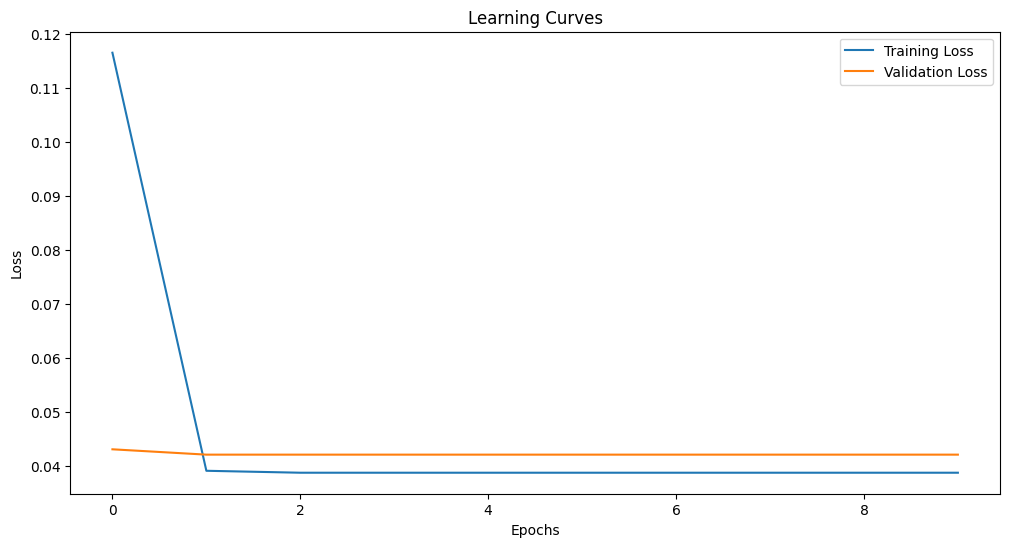

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'history' is the object returned by the `fit` method
plt.figure(figsize=(12, 6))

# Plot training loss
plt.plot(history.history['loss'], label='Training Loss')

# Plot validation loss
plt.plot(history.history['val_loss'], label='Validation Loss')

# Add title and labels
plt.title('Learning Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Add legend
plt.legend()

# Show plot
plt.show()


In [ ]:
predicted = autoencoder.predict(x_test_noisy)

1/1 [==============================] - 1s 600ms/step


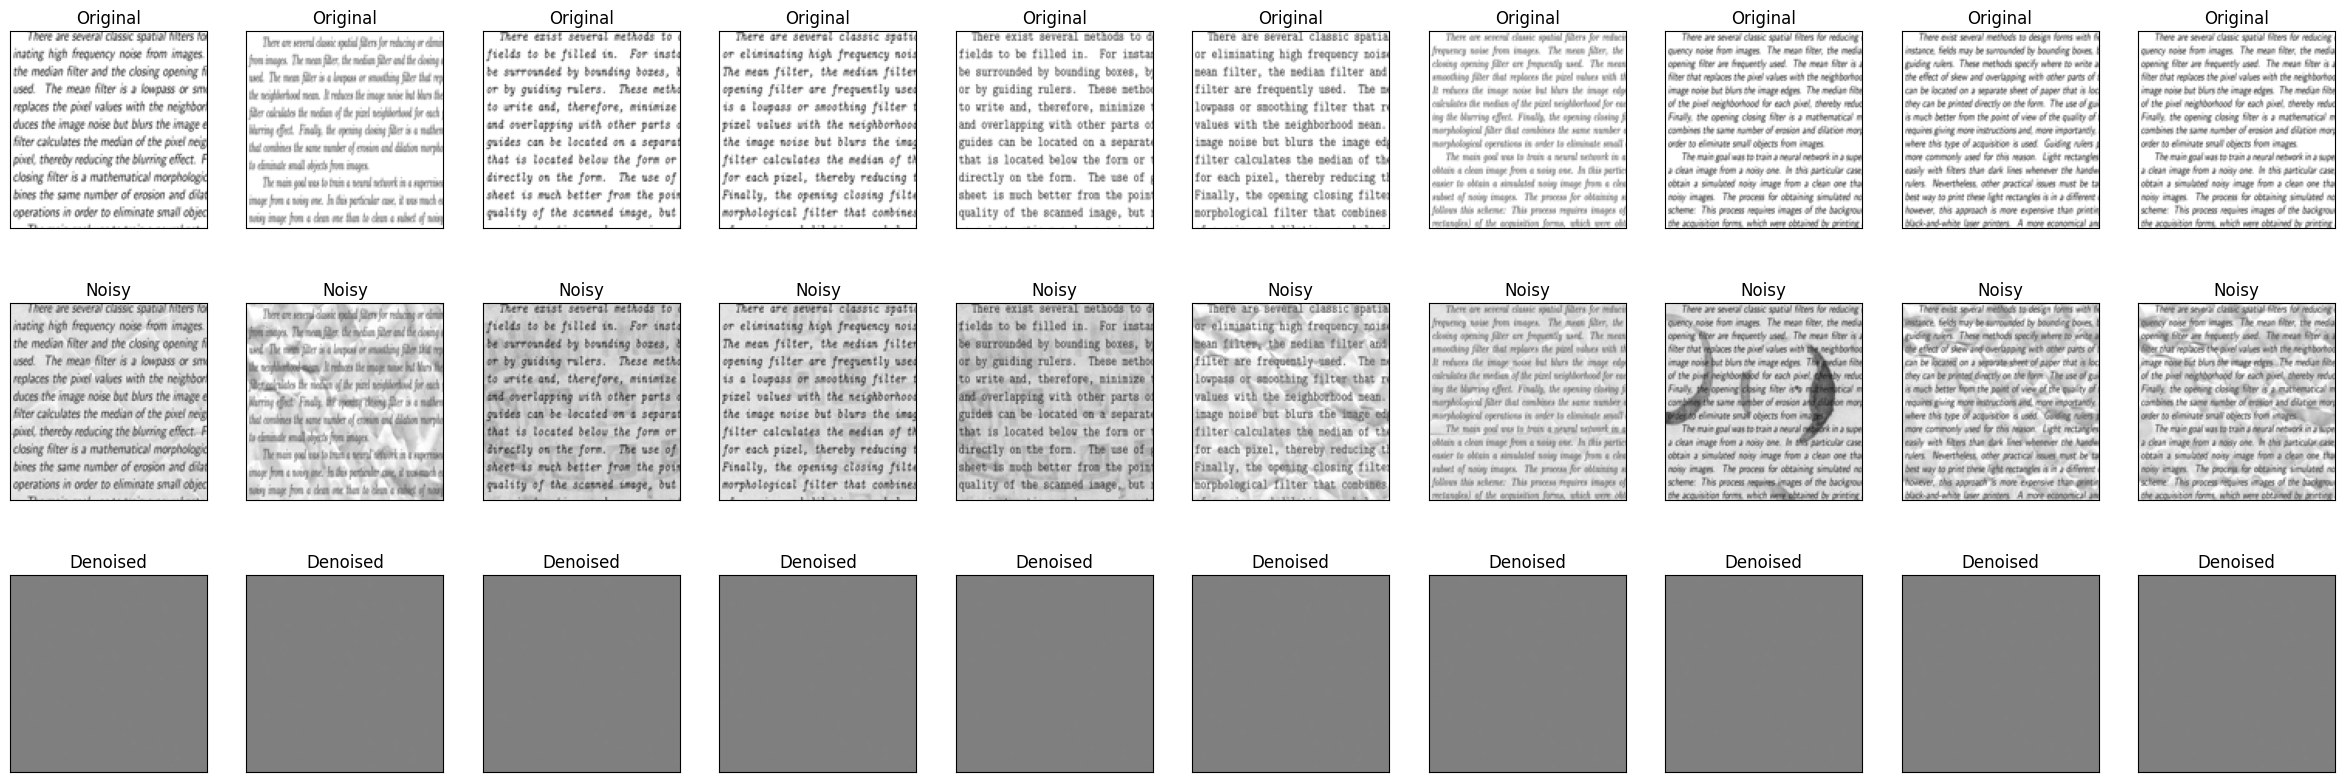

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have the arrays 'x_test_cleaned', 'x_test_noisy', and 'predicted' available
# Let's visualize the first 10 test images, their noisy counterparts, and their denoised versions
n = 10  # How many digits we will display
plt.figure(figsize=(30, 10))
for i in range(n):
    # Display original clean images
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test_cleaned[i].reshape(128, 128, 3))
    plt.gray()
    ax.set_title("Original")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display noisy images
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test_noisy[i].reshape(128, 128, 3))
    plt.gray()
    ax.set_title("Noisy")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display denoised images
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(predicted[i].reshape(128, 128, 3))
    plt.gray()
    ax.set_title("Denoised")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()


Epoch 1/5
10/10 [==============================] - 9s 704ms/step - loss: 0.0948 - val_loss: 0.0425
Epoch 2/5
10/10 [==============================] - 6s 561ms/step - loss: 0.0386 - val_loss: 0.0421
Epoch 3/5
10/10 [==============================] - 7s 674ms/step - loss: 0.0377 - val_loss: 0.0396
Epoch 4/5
10/10 [==============================] - 5s 527ms/step - loss: 0.0331 - val_loss: 0.0319
Epoch 5/5
10/10 [==============================] - 7s 683ms/step - loss: 0.0271 - val_loss: 0.0290


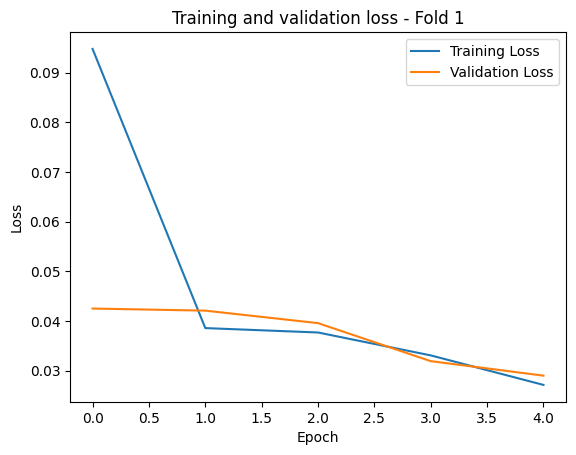

Epoch 1/5
10/10 [==============================] - 7s 560ms/step - loss: 0.0768 - val_loss: 0.0401
Epoch 2/5
10/10 [==============================] - 7s 675ms/step - loss: 0.0396 - val_loss: 0.0400
Epoch 3/5
10/10 [==============================] - 5s 524ms/step - loss: 0.0396 - val_loss: 0.0400
Epoch 4/5
10/10 [==============================] - 6s 653ms/step - loss: 0.0396 - val_loss: 0.0400
Epoch 5/5
10/10 [==============================] - 5s 557ms/step - loss: 0.0396 - val_loss: 0.0400


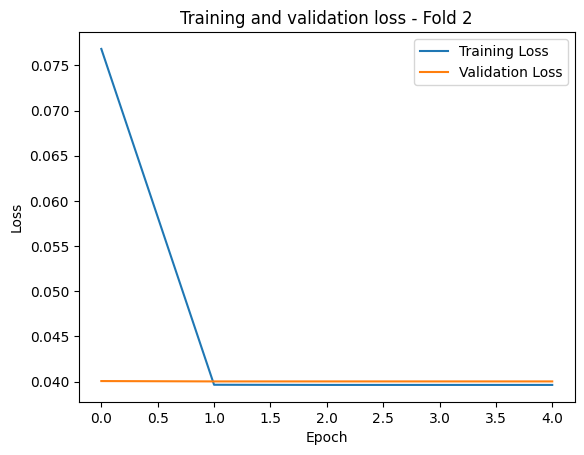

Epoch 1/5
10/10 [==============================] - 10s 731ms/step - loss: 0.0727 - val_loss: 0.0376
Epoch 2/5
10/10 [==============================] - 9s 871ms/step - loss: 0.0403 - val_loss: 0.0376
Epoch 3/5
10/10 [==============================] - 6s 648ms/step - loss: 0.0403 - val_loss: 0.0376
Epoch 4/5
10/10 [==============================] - 7s 647ms/step - loss: 0.0403 - val_loss: 0.0376
Epoch 5/5
10/10 [==============================] - 5s 522ms/step - loss: 0.0403 - val_loss: 0.0376


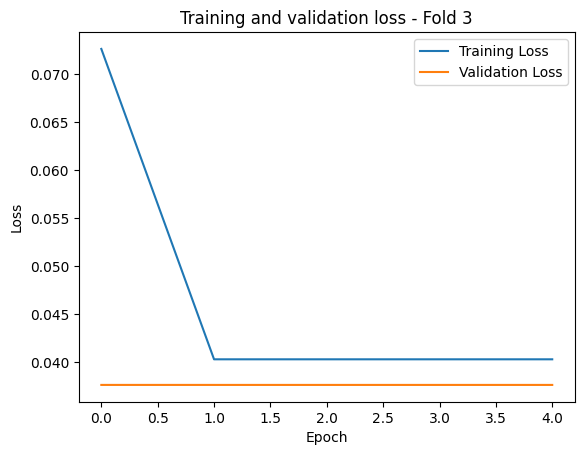

Epoch 1/5
10/10 [==============================] - 9s 701ms/step - loss: 0.0645 - val_loss: 0.0387
Epoch 2/5
10/10 [==============================] - 6s 577ms/step - loss: 0.0400 - val_loss: 0.0387
Epoch 3/5
10/10 [==============================] - 6s 665ms/step - loss: 0.0400 - val_loss: 0.0387
Epoch 4/5
10/10 [==============================] - 5s 547ms/step - loss: 0.0400 - val_loss: 0.0387
Epoch 5/5
10/10 [==============================] - 7s 684ms/step - loss: 0.0400 - val_loss: 0.0387


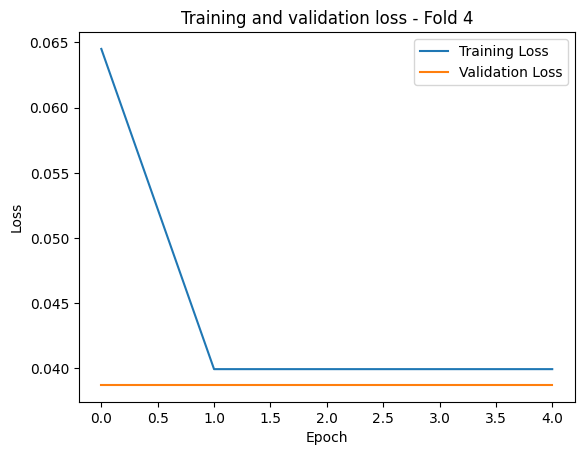

Epoch 1/5
10/10 [==============================] - 8s 587ms/step - loss: 0.0981 - val_loss: 0.0394
Epoch 2/5
10/10 [==============================] - 6s 606ms/step - loss: 0.0398 - val_loss: 0.0394
Epoch 3/5
10/10 [==============================] - 5s 527ms/step - loss: 0.0398 - val_loss: 0.0394
Epoch 4/5
10/10 [==============================] - 6s 647ms/step - loss: 0.0398 - val_loss: 0.0394
Epoch 5/5
10/10 [==============================] - 5s 532ms/step - loss: 0.0398 - val_loss: 0.0394


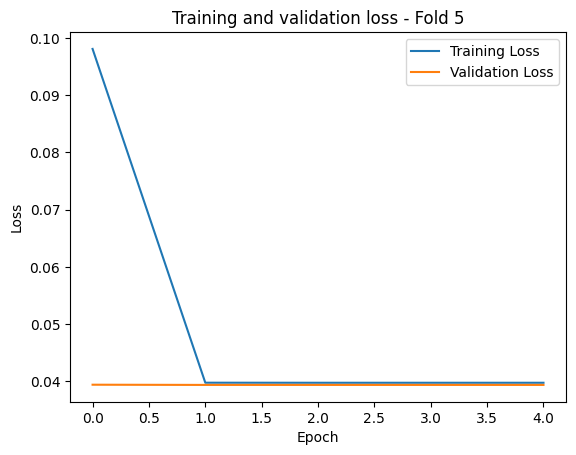

In [ ]:
from sklearn.model_selection import KFold
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.backend import clear_session

def create_autoencoder(input_shape):
    # Encoder
    input_img = Input(shape=input_shape, name='encoder_input')
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)  # Downsampling
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)  # Downsampling
    x = Flatten()(x)
    encoded = Dense(128, activation='relu')(x)  # Reduced size
    bottleneck = Dense(64, activation='relu', name='bottleneck')(encoded)  # Reduced bottleneck size

    # Decoder
    x = Dense(128, activation='relu')(bottleneck)  # Match to encoded size
    x = Dense(32 * 32 * 32, activation='relu')(x)  # Adjusted for downsampling
    x = Reshape((32, 32, 32))(x)  # Adjusted for downsampling
    x = UpSampling2D((2, 2))(x)  # Upsampling
    x = Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)  # Upsampling
    x = Conv2DTranspose(16, (3, 3), activation='relu', padding='same')(x)
    decoded = Conv2DTranspose(input_shape[2], (3, 3), activation='sigmoid', padding='same', name='decoder_output')(x)

    # Autoencoder Model
    autoencoder = Model(input_img, decoded, name='autoencoder')
    autoencoder.compile(optimizer='adam', loss='mean_squared_error')
    return autoencoder

# Number of splits for k-fold
num_folds = 3
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

fold_no = 1
for train, test in kf.split(x_cleaned):
    clear_session()
    # Create a new model for each fold
    autoencoder = create_autoencoder((128, 128, 3))

    # Get the data for the current fold
    x_train_noisy, x_train_cleaned = x_noisy[train], x_cleaned[train]
    x_test_noisy, x_test_cleaned = x_noisy[test], x_cleaned[test]

    # Normalize the data
    x_train_noisy, x_train_cleaned = x_train_noisy / 255.0, x_train_cleaned / 255.0
    x_test_noisy, x_test_cleaned = x_test_noisy / 255.0, x_test_cleaned / 255.0

    # Train the autoencoder
    history = autoencoder.fit(
        x_train_noisy, x_train_cleaned,
        epochs=5,
        batch_size=12,
        validation_data=(x_test_noisy, x_test_cleaned)
    )

    # Plotting the training/validation loss for the current fold
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Training and validation loss - Fold {fold_no}')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

    # Increase fold number
    fold_no += 1


In [ ]:
predicted = autoencoder.predict(x_test_noisy)


1/1 [==============================] - 1s 576ms/step


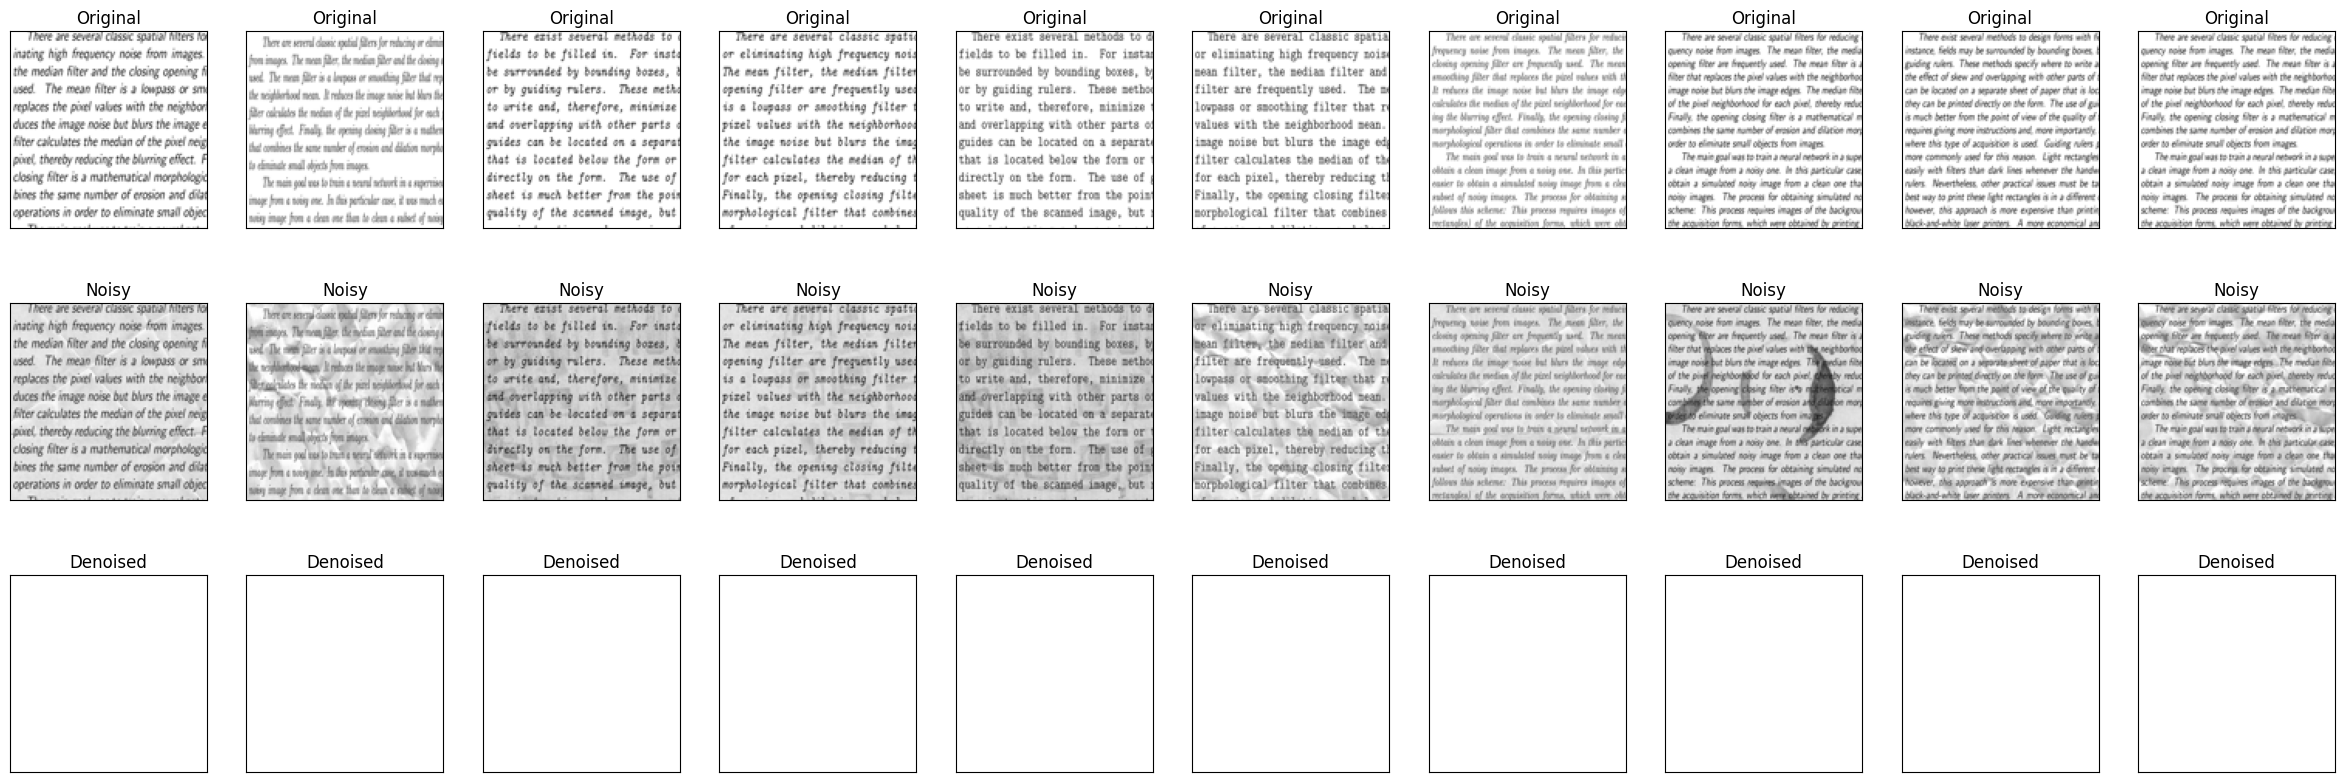

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have the arrays 'x_test_cleaned', 'x_test_noisy', and 'predicted' available
# Let's visualize the first 10 test images, their noisy counterparts, and their denoised versions
n = 10  # How many digits we will display
plt.figure(figsize=(30, 10))
for i in range(n):
    # Display original clean images
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test_cleaned[i].reshape(128, 128, 3))
    plt.gray()
    ax.set_title("Original")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display noisy images
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test_noisy[i].reshape(128, 128, 3))
    plt.gray()
    ax.set_title("Noisy")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display denoised images
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(predicted[i].reshape(128, 128, 3))
    plt.gray()
    ax.set_title("Denoised")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()


Based on the learning curves and the output you've provided, here are some inferences we can draw about the results:

**Decreasing Loss:** The training and validation losses decrease over the epochs, which indicates that the model is learning and improving in its task of denoising the images.

**Converging Loss**: y the final epoch, both training and validation losses seem to have converged to a stable value. This is a good sign that the model is not overfitting and is generalizing well to unseen data.

**Plateauing Validation Loss:** The validation loss plateaus quite quickly and remains consistent across epochs. This could imply that the model has learned as much as it can from the data, given its current architecture. It might also indicate that the model is too simple to capture more complex patterns in the data.

**Consistency Across Folds:** The performance across different folds seems to be consistent, which suggests that the model's performance is stable across different subsets of the data.

**Room for Improvement:** The fact that the validation loss stabilizes quickly may suggest that there is room for improvement.

**Model Complexity:** The rapid plateau of the loss suggests that the model might not be complex enough to further minimize the loss. You might need to increase the model's capacity by adding more layers or filters to capture more details.

**Due to limited RAM space the model's performace had to be reduced in order to reach to conclusions**